<a href="https://colab.research.google.com/github/jeverding/Deep-Learning-in-Medical-Imaging/blob/master/deep_medical_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning in Medical Imaging 

31.01.2020 

This project showcases how to use neural networks (e.g. CNNs) for medical imaging and diagnostics. 

I use the Chest X-Ray data provided by Paul Mooney through [kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) to predict pneumonia from x-ray scans of lungs. 
According to the [NHS](https://www.nhs.uk/conditions/pneumonia/), pneumonia is particularly difficult to diagnose as its symptoms such as coughing, feeling breathless, or having chest pain are quite similar to other illnesses like bronchitis or asthma, for instance (see also [here](https://www.nhlbi.nih.gov/health-topics/pneumonia)). 

X-rays are mainly used to diagnose pneumonia if symptoms do not improve within 48 hours of starting treatment. 

##Setup 

Import frameworks as usual: 

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, Reshape, Activation, BatchNormalization 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

TensorFlow 2.x selected.


Link Colab with kaggle (i.e. upload kaggle API as described [here](https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8) and [here](https://www.kaggle.com/general/74235)) to load data: 

In [3]:
from google.colab import files 
!pip install -q kaggle 

uploaded = files.upload() 
# use this to navigate to kaggle.json file and select for upload 

Saving kaggle.json to kaggle.json


Now change user permissions and browse/load data 

In [4]:
# move json file to directory and change file permissions (chmod 600: only owner can read and write)
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 
# browse available data, if interested 
#!kaggle datasets list 
!kaggle datasets download -d 'paultimothymooney/chest-xray-pneumonia' -p '/content'

 99% 2.28G/2.29G [00:47<00:00, 39.3MB/s]
100% 2.29G/2.29G [00:47<00:00, 51.5MB/s]


## Brief exploratory data analysis 

 Set directories 

In [5]:
#os.listdir('../input')
# Unzip and locate files: 
!unzip \*.zip
#!ls

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

/content/chest_xray/chest_xray
['.DS_Store', 'test', 'val', 'train']
/content/chest_xray/chest_xray/train
1342
3876


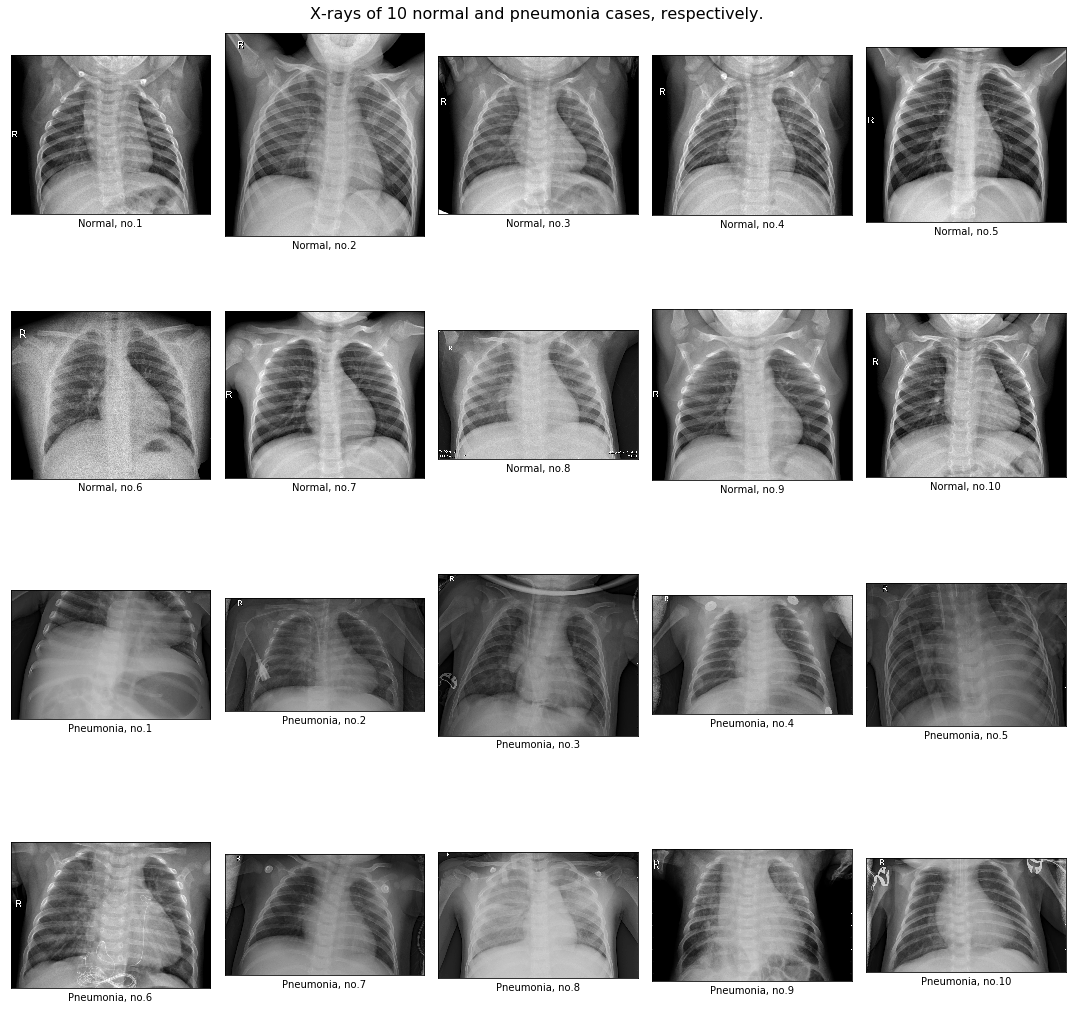

In [21]:
# set up directories 
main_dir = os.path.join(os.getcwd(), 'chest_xray/chest_xray') 
train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')
val_dir = os.path.join(main_dir, 'val')
train_n = os.path.join(train_dir, 'NORMAL')
train_p = os.path.join(train_dir, 'PNEUMONIA')
test_n = os.path.join(test_dir, 'NORMAL')
test_p = os.path.join(test_dir, 'PNEUMONIA')
val_n = os.path.join(val_dir, 'NORMAL')
val_p = os.path.join(val_dir, 'PNEUMONIA')

# Explore data (folder) structure 
print(main_dir)
print(os.listdir(main_dir))
print(train_dir)
print(len(os.listdir(train_n)))
print(len(os.listdir(train_p)))

# Save file names 
train_n_names = os.listdir(train_n)
train_p_names = os.listdir(train_p)
test_n_names = os.listdir(test_n)
test_p_names = os.listdir(test_p)
val_n_names = os.listdir(val_n)
val_p_names = os.listdir(val_p)

# plot first 10 (or individually set amount of) images of both normal and pneumonia x-rays, from training or test data, for instance 
def plt_classes(img_dir = train_dir, img_per_class = 10, img_size = (15,15)):
  plt.figure(figsize = img_size)
  for i in range(img_per_class):
    plt.subplot(4,img_per_class//2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    x = plt.imread(os.path.join(os.path.join(img_dir, 'NORMAL'),os.listdir(os.path.join(img_dir, 'NORMAL'))[i]))
    plt.imshow(x, cmap = 'gray')
    plt.xlabel('Normal, no.' + str(i+1))
  for i in range(img_per_class):
    plt.subplot(4,img_per_class//2,i+1+img_per_class)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    x = plt.imread(os.path.join(os.path.join(img_dir, 'PNEUMONIA'),os.listdir(os.path.join(img_dir, 'PNEUMONIA'))[i]))
    plt.imshow(x, cmap = 'gray')
    plt.xlabel('Pneumonia, no.' + str(i+1))
  plt.tight_layout()
  plt.suptitle('X-rays of 10 normal and pneumonia cases, respectively.', fontsize = 16)
  plt.show()

plt_classes()
#plt_classes(img_dir=test_dir)

## Data pre-processing 

Further steps setting up data pipeline. 

In specific, I rescale the training, test, and validation data here. 
The pre-processing of the training data involves additional steps of data manipulation such as focussing on specific parts (*zoom_range*) and shearing of the images. 

Regarding the batch sizes, I stick with the default size for the training data (i.e. 32) after playing around with some larger and smaller values as well as researching how to determine optimal values (see e.g. [here](https://stackoverflow.com/questions/54413160/training-validation-testing-batch-size-ratio) and ). Despite improvements concerning the runtime of the algorithm, choosing an overly large batch size is arguably undersirable for training due to reduced ability to generalize from learnt structures (see e.g. [here](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network) and [Keskar et al. 2016](https://arxiv.org/abs/1609.04836)). Following [Goodfellow et al. , p. 276](http://www.deeplearningbook.org/contents/optimization.html), I try different training batch sizes in the range of 32 to 256. 

Concerning the batch sizes of the test and validation data, I simply use the default values (i.e. 32) and alternatively tried setting them as high as possible (see e.g. [here](https://stackoverflow.com/questions/54413160/training-validation-testing-batch-size-ratio)). 

In [161]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.15,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1./255) 

# set parameters 
image_size = (64, 64)
train_batch_size = 32 # higher values such as 128 do not perform well with the given data 
vt_batch_size = 32 

# now actually preprocess training, test, and validation data 
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size = image_size,
                                              batch_size = train_batch_size, 
                                              shuffle = True, 
                                              class_mode = 'categorical', 
                                              color_mode = 'grayscale')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = image_size,
                                            batch_size = vt_batch_size, 
                                            class_mode = 'categorical', #alternatively, could also use 'binary', which would however affect the model design and compliation 
                                            color_mode = 'grayscale')
val_set = test_datagen.flow_from_directory(val_dir,
                                           target_size = image_size,
                                           batch_size = vt_batch_size, 
                                           class_mode ='categorical',
                                           color_mode = 'grayscale')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Create model 

I build a simple, sequential CNN model here using 2D convolutional layers, batch norm, and *relu* as an activation function. Moreover, I employ Keras' functional API (see [here](https://www.tensorflow.org/guide/keras/functional)). 
For simplicity, I do not set up layers in parallel though. After the first set of layers, I flatten the data and proceed with dense layers (where I use dropout in addition to batch norm). 

In [163]:
# build model 
img_input=Input(shape=train_set.image_shape, name='img_input') 
x=Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False, name='1st_Conv2D')(img_input) # no bias necessary before batch norm
x=BatchNormalization(scale=False, center=True)(x) # no batch norm scaling necessary before "relu"
x=Activation('relu')(x) # activation after batch norm

x=Conv2D(filters=24, kernel_size=3, padding='same', use_bias=False, strides=2, name='2nd_Conv2D')(x)
x=BatchNormalization(scale=False, center=True)(x)
x=Activation('relu')(x)

x=Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False, strides=1, name='2.5nd_Conv2D')(x)
x=BatchNormalization(scale=False, center=True)(x)
x=Activation('relu')(x)

x=Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2, name='3nd_Conv2D')(x)
x=BatchNormalization(scale=False, center=True)(x)
x=Activation('relu')(x)

x=Flatten()(x)
x=Dense(200, use_bias=False)(x)
x=BatchNormalization(scale=False, center=True)(x)
x=Activation('relu')(x)
x=Dense(100, use_bias=False)(x)
x=BatchNormalization(scale=False, center=True)(x)
x=Activation('relu')(x)
x=Dropout(0.3)(x) # Dropout on dense layer only
output=Dense(2, activation='softmax', name='img_output')(x)

model=Model(inputs=img_input, outputs=output, name='func_model')

# set learning rate 
set_lr=0.00015 # Alternative learning rates tried were the default (0.001), 0.0001, 0.0002 and 0.0005
# compile model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=set_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "func_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 64, 64, 1)]       0         
_________________________________________________________________
1st_Conv2D (Conv2D)          (None, 64, 64, 12)        108       
_________________________________________________________________
batch_normalization_201 (Bat (None, 64, 64, 12)        36        
_________________________________________________________________
activation_201 (Activation)  (None, 64, 64, 12)        0         
_________________________________________________________________
2nd_Conv2D (Conv2D)          (None, 32, 32, 24)        2592      
_________________________________________________________________
batch_normalization_202 (Bat (None, 32, 32, 24)        72        
_________________________________________________________________
activation_202 (Activation)  (None, 32, 32, 24)        0

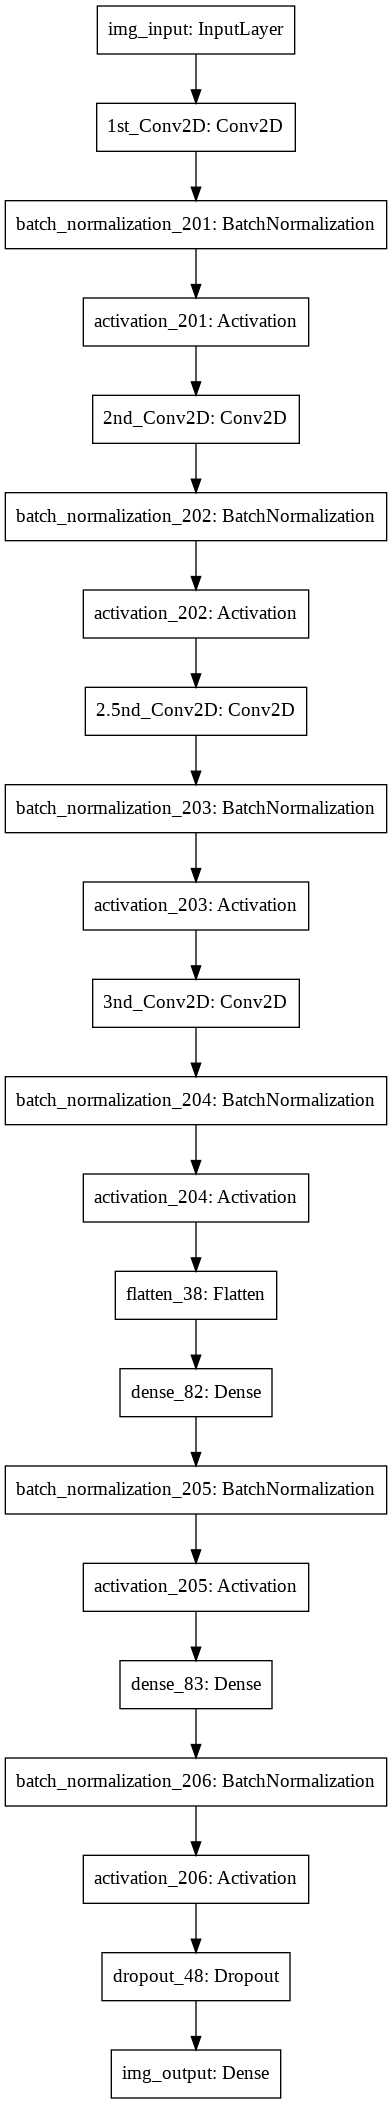

In [164]:
# Alternatively, plot model as graph
tf.keras.utils.plot_model(model) #, 'simple_cnn_func_model.png') #, show_shapes=True)

In [166]:
# now fit the compiled model on the training data: 
history=model.fit(train_set,
                  steps_per_epoch = train_set.n // train_set.batch_size, 
                  epochs = 10,
                  validation_data = val_set,
                  validation_steps = val_set.n // val_set.batch_size)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 163 steps, validate for 1 steps
Epoch 1/10
163/163 [==============================] - 45s 279ms/step - loss: 0.4131 - accuracy: 0.8336 - val_loss: 1.2469 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 45s 274ms/step - loss: 0.2155 - accuracy: 0.9260 - val_loss: 1.6296 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 45s 274ms/step - loss: 0.1929 - accuracy: 0.9291 - val_loss: 1.1193 - val_accuracy: 0.5625
Epoch 4/10
163/163 [==============================] - 44s 273ms/step - loss: 0.1693 - accuracy: 0.9390 - val_loss: 0.8312 - val_accuracy: 0.6875
Epoch 5/10
163/163 [==============================] - 45s 273ms/step - loss: 0.1524 - accuracy: 0.9429 - val_loss: 0.5302 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 44s 271ms/step - loss: 0.1527 - accuracy: 0.9444 - val_loss: 1.0649 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==================

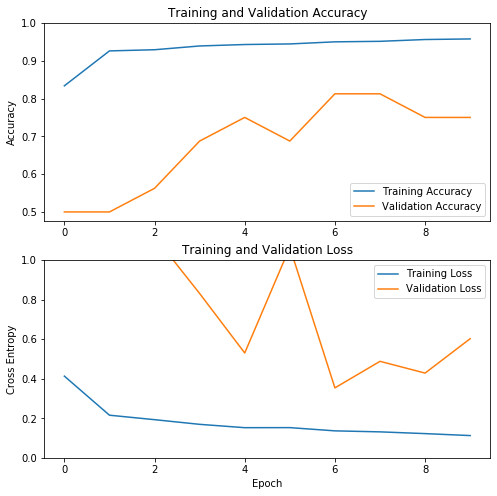

In [167]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

### Evaluate model performance 

Eventually, I also evaluate the performance of the model using the test data. 

In [169]:
results = model.evaluate(test_set)
print('Model loss evaluated on the test data: {:.2f}%'.format(results[0] * 100))
print('Model accuracy evaluated on the test data: {:.2f}%'.format(results[1] * 100))

  ...
    to  
  ['...']
20/20 [==============================] - 4s 219ms/step - loss: 0.3134 - accuracy: 0.9038
Model loss evaluated on the test data: 31.34%
Model accuracy evaluated on the test data: 90.38%


Overall, the model performance as assessed using the testing loss and accuracy seems quite satisfactory. 

However, there appears to be some overfitting (for instance, val. loss increases after 6th epoch although training loss continues to slightly decrease). 
I tried to address this potential issue using dropout (i.e. regularization), among others. 

Alternatively, one could implement specific techniques such as EarlyStopping or ModelCheckpoint to selectively stop the training before the model begins to overfit. Given that these approaches lie outside the focus of this exercise, I simply provide links which I considered helpful for further reading: 

[Tensorflow on EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) 

[Keras on Callbacks](https://keras.io/callbacks/) 

[MachineLearningMastery on a range of methods to stop model training](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

## Additional, simple analysis 

To simply illustrate a different, arguably more naive approach to analyzing the data for predicting pneumonia, I revisit the data pipeline and model to implement a couple of tweaks. 

### Data pre-processing, part 2 

Carefully adjusted pre-processing routine. 
For instance, I now use a larger image target size than before (`(128, 128)`), slightly change the batch sizes (for test and val. data) and include several new data manipulation steps (e.g. shifting the data, in addition to randomly zooming into certain parts of the images). 

In [170]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.15,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range = 33,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25
)
test_datagen = ImageDataGenerator(rescale = 1./255) 

# set parameters 
image_size = (128, 128)
train_batch_size = 32 # higher values such as 128 do not perform well with the given data 
vt_batch_size = 32 

# now actually preprocess training, test, and validation data 
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size = image_size,
                                              batch_size = train_batch_size, 
                                              shuffle = True, 
                                              class_mode = 'categorical', 
#when using categorical instead of binary class, use softmax activation with 2 classes in output layer of model and compile with cat.crossentropy
                                              color_mode = 'grayscale')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = image_size,
                                            batch_size = vt_batch_size, 
                                            class_mode = 'categorical',
                                            color_mode = 'grayscale')
val_set = test_datagen.flow_from_directory(val_dir,
                                           target_size = image_size,
                                           batch_size = vt_batch_size, 
                                           class_mode ='categorical',
                                           color_mode = 'grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Create alternative model 

First, try implementing a model that is somewhat simpler using Keras' `model.add` syntax. 
Specifically, the model mainly consists of fully connected layers with dropout to address potential issues of overfitting, and one additional convolutional layer.

This approach moreover employs the sequential api of Keras (see [here](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)). 

In [178]:
model = tf.keras.Sequential(name='simple_seq_model')

model.add(Conv2D(128, (3, 3), input_shape=train_set.image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'softmax')) 

model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), # the default learning rate is 0.001. Alternatively to this optimizer, could just as well use: 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "simple_seq_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 128)     1280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 508032)            0         
_________________________________________________________________
dense_99 (Dense)             (None, 1000)              508033000 
_________________________________________________________________
dropout_56 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 300)               300300    
_________________________________________________________________
dense_101 (Dense)            (None, 100)          

In [179]:
history = model.fit(train_set,
                        steps_per_epoch = train_set.n // train_set.batch_size, 
                        epochs = 10,
                        validation_data = val_set,
                        validation_steps = val_set.n // val_set.batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 163 steps, validate for 1 steps
Epoch 1/10
163/163 [==============================] - 54s 331ms/step - loss: 0.6452 - accuracy: 0.6988 - val_loss: 0.7864 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 53s 325ms/step - loss: 0.4941 - accuracy: 0.7575 - val_loss: 0.5549 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 53s 326ms/step - loss: 0.4007 - accuracy: 0.8085 - val_loss: 0.5794 - val_accuracy: 0.7500
Epoch 4/10
163/163 [==============================] - 53s 328ms/step - loss: 0.3449 - accuracy: 0.8401 - val_loss: 0.6888 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 53s 326ms/step - loss: 0.3271 - accuracy: 0.8480 - val_loss: 0.5068 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 53s 328ms/step - loss: 0.2908 - accuracy: 0.8654 - val_loss: 0.4183 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==================

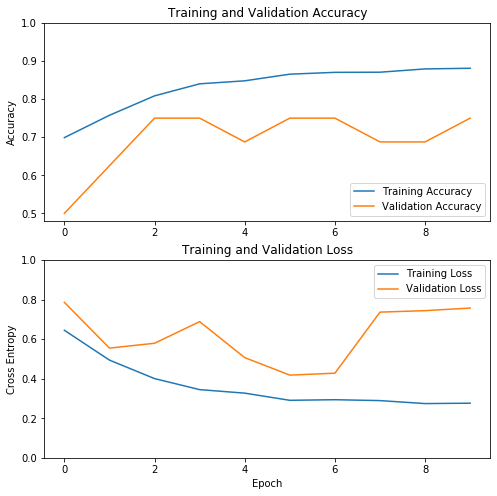

In [180]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

### Evaluate model performance 

I again evaluate the performance of the model using the test data. 

In [181]:
results = model.evaluate(test_set)
print('Model loss evaluated on the test data: {:.2f}%'.format(results[0] * 100))
print('Model accuracy evaluated on the test data: {:.2f}%'.format(results[1] * 100))

  ...
    to  
  ['...']
20/20 [==============================] - 5s 229ms/step - loss: 0.3905 - accuracy: 0.8462
Model loss evaluated on the test data: 39.05%
Model accuracy evaluated on the test data: 84.62%


Compared to the more complex model above (as well as in absolute terms), this simple model performs quite poorly. 

Also, see section above regarding overfitting. 

## Implement transfer learning 

Eventually, I use Google's **MobileNet V2** model to illustrate the application of transfer learning, which is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

### Specific data preparation 

For the application of imagenet weights, an RGB style image input is needed (for a more general discussion, see e.g. [here](https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images)). That is, I need to set up a data pipeline without specifiying the `color_mode` as `'grayscale'`. 

To illustrate a different approach of handling the data structure (binary classification), I use the `class_mode` binary now - which then also affects the way the model is set up (see below).  

In [215]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.15,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1./255) 

# set parameters 
image_size = (128, 128)
train_batch_size = 32 
vt_batch_size = 32 

# now actually preprocess training, test, and validation data 
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size = image_size,
                                              batch_size = train_batch_size, 
                                              shuffle = True, 
                                              class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = image_size,
                                            batch_size = vt_batch_size, 
                                            class_mode = 'binary')
val_set = test_datagen.flow_from_directory(val_dir,
                                           target_size = image_size,
                                           batch_size = vt_batch_size, 
                                           class_mode ='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Create model based on MobileNet2

In [216]:
# Load MobileNet2 
base_model=tf.keras.applications.MobileNetV2(input_shape=train_set.image_shape, 
                                             include_top=False,
                                             weights='imagenet')

# Define additional/case-specific layers and final model 
average_layer=tf.keras.layers.GlobalAveragePooling2D()
prediction_layer=Dense(2, activation='softmax')
model = Sequential([
  base_model,
  average_layer,
  prediction_layer
],name='transfer_model')

# Compile model 
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "transfer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_11  (None, 1280)              0         
_________________________________________________________________
dense_114 (Dense)            (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [217]:
# Check out how many weights need to be specified in the model (out of the total, pre-trained model)
len(model.trainable_variables)

158

In [218]:
history = model.fit(train_set,
                    epochs = 10,
                    validation_data = val_set)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 163 steps, validate for 1 steps
Epoch 1/10
163/163 [==============================] - 73s 445ms/step - loss: 0.1759 - accuracy: 0.9379 - val_loss: 8.3851 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 68s 416ms/step - loss: 0.0843 - accuracy: 0.9682 - val_loss: 5.5768 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 68s 417ms/step - loss: 0.0677 - accuracy: 0.9735 - val_loss: 0.6624 - val_accuracy: 0.7500
Epoch 4/10
163/163 [==============================] - 69s 421ms/step - loss: 0.0560 - accuracy: 0.9797 - val_loss: 0.3580 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 68s 418ms/step - loss: 0.0520 - accuracy: 0.9808 - val_loss: 1.6014 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 68s 415ms/step - loss: 0.0541 - accuracy: 0.9787 - val_loss: 1.1065 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==================

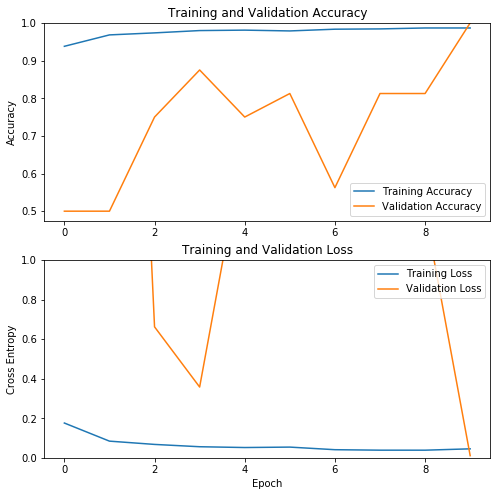

In [219]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

### Evaluate model performance 

Just as before, evaluate the performance of the transfer learning model: 

In [220]:
results = model.evaluate(test_set)
print('Model loss evaluated on the test data: {:.2f}%'.format(results[0] * 100))
print('Model accuracy evaluated on the test data: {:.2f}%'.format(results[1] * 100))

  ...
    to  
  ['...']
20/20 [==============================] - 5s 258ms/step - loss: 0.5667 - accuracy: 0.9183
Model loss evaluated on the test data: 56.67%
Model accuracy evaluated on the test data: 91.83%


# Concluding remarks 

The complexer model performs already quite good (approximately 90% testing accuracy), the arguably simple model not so much (less than 85% testing accuracy). 

The transfer learning model based on MobileNet2 does a great job at predicting pneumonia from the x-ray scans (almost 92% testing accuracy). 
It might be possible to increase the performance of this model even further again considering the techniques for addressing overfitting discussed above (e.g. EarlyStopping). 
Alternatively, one could also unfreeze some of the layers and design a more complex model building on the MobileNet2 - or maybe even another pre-trained model. 

Overall, the different models clearly highlight the potential of deep learning in medical imaging. 